In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import ICRS, SkyCoord

from sklearn.cluster import DBSCAN

In [65]:
sources: pd.DataFrame = pd.read_csv('./data/ngc_188/2_deg.csv', index_col=None)

In [66]:
sources.head()

,source_id,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error
0,574509467058245248,35.762865,85.164665,0.545239,0.034492,3.247654,0.041664,-1.847557,0.038611
1,574509497122163968,35.809630,85.163901,1.030282,0.305369,3.574122,0.340190,-11.069103,0.322297
2,574509497122165760,35.790532,85.170221,0.700458,0.150817,1.392000,0.170484,-5.308261,0.161823
3,574509497122168832,35.881362,85.173814,1.019159,0.095813,7.129422,0.111451,-1.815068,0.103988
4,574509497122532096,35.863571,85.172798,0.800303,0.247038,-1.281005,0.256265,-2.856644,0.247990


In [67]:
sources_clean: pd.DataFrame = sources[['ra', 'dec', 'parallax', 'pmra', 'pmdec']].dropna()
sky_coords: list[SkyCoord] = SkyCoord(ra=sources_clean.ra.values,
                                      dec=sources_clean.dec.values,
                                      unit=(u.deg, u.deg),
                                      frame=ICRS)

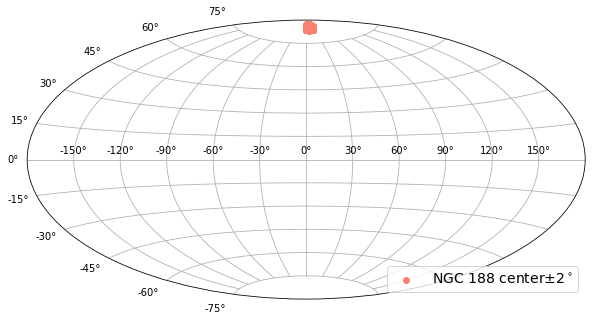

In [68]:
plt.figure(figsize=(10, 7))
plt.subplot(111, projection="aitoff")
plt.scatter(sky_coords.ra.radian, sky_coords.dec.radian, color='salmon', label=r'NGC 188 center$\pm 2^\circ$')
plt.grid()
plt.legend(loc='lower right', fontsize=14)

In [69]:
sources_clean['m_distance'] = 1/sources_clean['parallax']

In [81]:
clust = DBSCAN(eps=.5, min_samples=100)
fit = clust.fit(sources_clean)

labels = fit.labels_
print(set(labels))

sources_clean['label'] = labels

{0, -1}


In [82]:
sources_clean.loc[sources_clean['label']==0].head()

,ra,dec,parallax,pmra,pmdec,m_distance,label
38495,10.732846,84.682801,0.523439,-2.243342,-1.435318,1.910441,0
38661,12.510134,84.833817,0.721260,-2.385058,-0.850983,1.386463,0
38680,12.264538,84.907228,0.532028,-2.327775,-1.111840,1.879600,0
38687,11.786204,84.867786,0.572127,-2.330531,-1.122411,1.747864,0
38723,11.132328,84.859734,0.574330,-2.364937,-1.123498,1.741159,0


In [83]:
sources_labeled = sources_clean[sources_clean['label']==0]
len(sources_labeled)

659

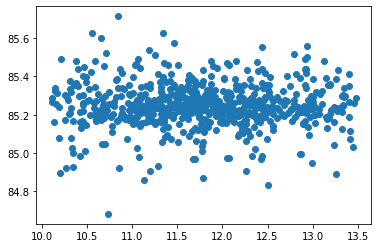

In [84]:
plt.scatter(sources_labeled.ra, sources_labeled.dec)

In [89]:
galactic_coords_labeled: list[SkyCoord] = SkyCoord(ra=sources_labeled.ra.values,
                                                   dec=sources_labeled.dec.values,
                                                   unit=(u.deg, u.deg),
                                                   frame=ICRS).galactic

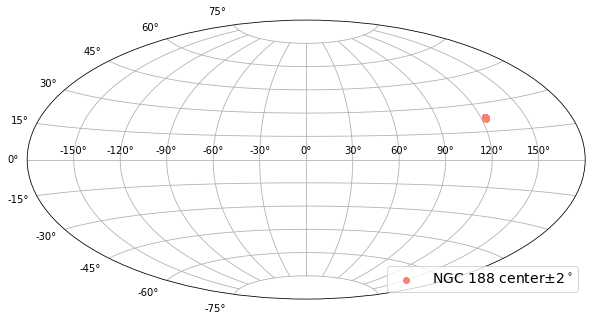

In [90]:
plt.figure(figsize=(10, 7))
plt.subplot(111, projection="aitoff")
plt.scatter(galactic_coords_labeled.l.radian, galactic_coords_labeled.b.radian, color='salmon', label=r'NGC 188 center$\pm 2^\circ$')
plt.grid()
plt.legend(loc='lower right', fontsize=14)

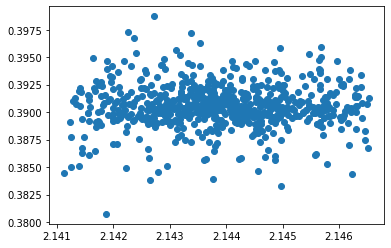

In [91]:
plt.scatter(galactic_coords_labeled.l.radian, galactic_coords_labeled.b.radian)